In [191]:
from datetime import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt;
import time
import backtrader as bt
from datalib import get_data

In [192]:
startdate = datetime(2018, 4, 18)
enddate = datetime.now()

instruments = [
    'VGLT-STK-ARCA',
    'VOO-STK-ARCA',
    'VOX-STK-ARCA',
    'VCR-STK-ARCA',
    'VDC-STK-ARCA',
    'VDE-STK-ARCA',
    'VFH-STK-ARCA',
    'VHT-STK-ARCA',
    'VIS-STK-ARCA',
    'VGT-STK-ARCA',
    'VAW-STK-ARCA',
    'VNQ-STK-ARCA',
    'VPU-STK-ARCA',
]
dfs_ = get_data(instruments, startdate = startdate, enddate = enddate,timeframe=bt.TimeFrame.Days,compression=1)

VGLT-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:22:53 GMT
VOO-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:22:58 GMT
VOX-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:23:02 GMT
VCR-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:23:06 GMT
VDC-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:23:10 GMT
VDE-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:23:21 GMT
VFH-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:23:39 GMT
VHT-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:23:57 GMT
VIS-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:24:01 GMT
VGT-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:24:05 GMT
VAW-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:24:09 GMT
VNQ-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:24:15 GMT
VPU-STK-ARCA
Server Version: 76
TWS Time at connection:20210427 16:24:33 GM

In [193]:
dfs = 1*dfs_

In [194]:
# silence pandas warning to make this feel like rl
pd.set_option('mode.chained_assignment', None)

In [195]:
if False:
    L = tradeLength
    burnin = 10
    bb_max = [0]*burnin
    bb_min = [0]*burnin
    alpha = 0
    X = df['close'].ewm(com=alpha).mean()
    for i in range(burnin,len(X)):
        e = i 
        s = max(0,i-L)
        slope = (X[e] - X[s]) / (e-s)
        residual = X[s:e+1]-(X[s]+np.arange(e-s +1)*slope)
        bb_max.append(residual.max())
        bb_min.append(residual.min())
    df['bb_max_'] = bb_max
    df['bb_min_'] = bb_min
    df['bb_max'] = bb_max + X
    df['bb_min'] = bb_min + X
    df[['bb_max','bb_min','close']].tail(10*L).plot()

## Input Features

In [196]:
ws = [22,63]
signals = {}
for w in ws:
    p_ = dfs['close'].rolling(w,min_periods=1)
    r_ = dfs['close'].pct_change().fillna(0)
    v_ = dfs["volume"].fillna(0).rolling(w,min_periods=1)
    rp_ = (r_ * (r_>0)).ewm(com=w)
    rn_ = (r_ * (r_<0)).ewm(com=w)
    signals[f"ratio_{w}"] = dfs["close"]/p_.mean()
    signals[f"min_{w}"] =  dfs["close"]/p_.min()
    signals[f"max_{w}"] =  dfs["close"]/p_.max()
    signals[f"v_ratio_{w}"] = dfs["volume"]/v_.mean()
    signals[f"v_min_{w}"] = dfs["volume"]/v_.min()
    signals[f"v_max_{w}"] = dfs["volume"]/v_.min()
    signals[f"std_{w}"] =  r_.ewm(com=w).std().fillna(0)
    signals[f"stdp_{w}"] = rp_.std().fillna(0)
    signals[f"stdn_{w}"] = rn_.std().fillna(0)
    signals[f"kurt"] = p_.kurt().fillna(0)
    signals[f"skew"] = p_.skew().fillna(0)


dfs = dfs.join(pd.DataFrame(signals))
signals_ = signals

## Target Values

In [197]:
duration = 22*3
targets = {}
targets["target_max"] = dfs["close"].shift(-1*(duration-1)).rolling(duration,min_periods=1).max()
targets["target_min"] = dfs["close"].shift(-1*(duration-1)).rolling(duration,min_periods=1).min()

targets["log_target_max"] = np.log(dfs["close"].shift(-1*(duration-1)).rolling(duration,min_periods=1).max())
targets["log_target_min"] = np.log(dfs["close"].shift(-1*(duration-1)).rolling(duration,min_periods=1).min())
targets["log_close"] = np.log(dfs["close"])
dfs = dfs.join(pd.DataFrame(targets))

## Model

In [198]:
import tensorflow as tf
tf.enable_eager_execution()

In [199]:
f_sigs = list(signals_.keys())
f_base = ["log_close","log_close"]

f_target = ["log_target_max","log_target_min"]

In [201]:
X_s = np.einsum("itv->tiv",np.array([dfs.loc[inst][f_sigs] for inst in instruments])).astype(np.float32)
X_b = np.einsum("itv->tiv",np.array([dfs.loc[inst][f_base] for inst in instruments])).astype(np.float32)
Y = np.einsum("itv->tiv",np.array([dfs.loc[inst][f_target] for inst in instruments])).astype(np.float32)
X_s.shape,X_b.shape,Y.shape

((790, 13, 20), (790, 13, 2), (790, 13, 2))

In [202]:
X_pos = []
for i in range(X_s.shape[1]):
    X_pos.append(np.hstack([X_s[:,i,:],np.array([np.eye(X_s.shape[1])[i]]*X_s.shape[0])]))
X_pos = np.array(X_pos).astype(np.float32)

In [203]:
X_s = np.einsum("itv->tiv",X_pos)

In [204]:
test_length = int(X_s.shape[0]*0.25)

In [172]:
signals = tf.keras.layers.Input(shape=(X_s.shape[1],X_s.shape[2]))
base = tf.keras.layers.Input(shape=(X_b.shape[1],X_b.shape[2]))


def OneLayer(signals):
    L = 20
    d = 0.05
    
    q = tf.keras.layers.Dense(L,activation='tanh')(signals)
    q = tf.keras.layers.Dropout(d)(q)
    q = tf.keras.layers.Dense(L,activation='tanh')(q)
    q = tf.keras.layers.Dropout(d)(q)
    query = tf.keras.layers.Dense(X_s.shape[2])(q)

    k = tf.keras.layers.Dense(L,activation='tanh')(signals)
    k = tf.keras.layers.Dropout(0.1)(k)
    k = tf.keras.layers.Dense(L,activation='tanh')(k)
    k = tf.keras.layers.Dropout(0.1)(k)
    key = tf.keras.layers.Dense(X_s.shape[2])(k)
    
    v = tf.keras.layers.Dense(L,activation='tanh')(signals)
    v = tf.keras.layers.Dropout(0.1)(v)
    v = tf.keras.layers.Dense(L,activation='tanh')(v)
    v = tf.keras.layers.Dropout(0.1)(v)
    values = tf.keras.layers.Dense(X_s.shape[2])(v)

    m = tf.keras.layers.Dense(L,activation='tanh')(signals)
    m = tf.keras.layers.Dropout(0.1)(m)
    m = tf.keras.layers.Dense(L,activation='tanh')(m)
    m = tf.keras.layers.Dropout(0.1)(m)
    m = tf.keras.layers.Dense(len(instruments))(m)
    m = tf.reshape(m,[-1,len(instruments),len(instruments)])


    scores = tf.einsum("tqf,tkf->tqk",query, key)
    distribution = tf.nn.softmax(scores+m,axis=-1)
    #distribution = tf.nn.softmax(scores, axis=-1)

    modulated = tf.einsum("tkv,tvf->tkf",distribution,values)
    return modulated +signals

x = signals 
for i in range(2):
    x = OneLayer(x)
out = base + tf.keras.layers.Dense(X_b.shape[2])(x)
model = tf.keras.Model(inputs=[signals,base], outputs=out)

In [173]:
model.compile(
  loss=tf.keras.losses.MSE,
  optimizer=tf.keras.optimizers.Adam(lr=0.001),
  metrics=["MSE"],
)

In [174]:
test_scores = model.evaluate([X_s[-test_length:,:,:],X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

197/197 - 1s - loss: 6.2543 - mean_squared_error: 6.2543
Test MSE: 6.254279177806099
Test MSE: 6.2542796


In [179]:
model.fit([X_s[:-test_length,:,:],X_b[:-test_length,:,:]], Y[:-test_length,:,:], batch_size=16, epochs=100, validation_split=0.1)
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

Train on 533 samples, validate on 60 samples
Epoch 1/100
533/533 [==============================] - 0s 589us/sample - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 2/100
533/533 [==============================] - 0s 572us/sample - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 3/100
533/533 [==============================] - 0s 563us/sample - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 4/100
533/533 [==============================] - 0s 484us/sample - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 5/100
533/533 [==============================] - 0s 517us/sample - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0158 - val_mean_squared_error: 0.0158
Epoch 6/100
533/533 [==============================] - 0s 737us/sample - loss: 0.0176 - mean_squared_error: 0.0176 - val

533/533 [==============================] - 0s 475us/sample - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 50/100
533/533 [==============================] - 0s 520us/sample - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 51/100
533/533 [==============================] - 0s 643us/sample - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 52/100
533/533 [==============================] - 0s 514us/sample - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 53/100
533/533 [==============================] - 0s 514us/sample - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 54/100
533/533 [==============================] - 0s 489us/sample - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch

Epoch 98/100
533/533 [==============================] - 0s 596us/sample - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 99/100
533/533 [==============================] - 0s 670us/sample - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 100/100
533/533 [==============================] - 0s 529us/sample - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
197/197 - 0s - loss: 0.1610 - mean_squared_error: 0.1610
Test MSE: 0.16101067524573526
Test MSE: 0.16101068


In [183]:
nn= np.array(model([X_s,X_b]));

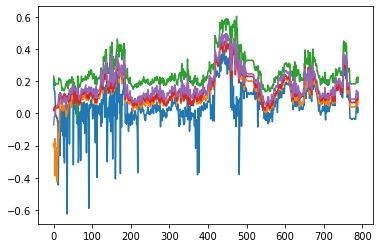

In [184]:
plt.plot(nn[:,:,0]-nn[:,:,1])


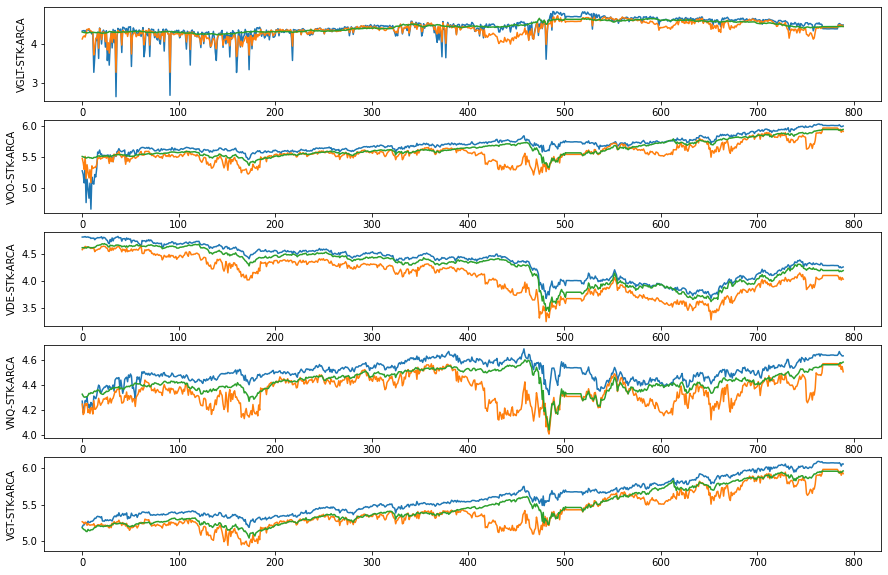

In [185]:
plt.figure(figsize=(15,10))
N = len(instruments)
for i in range(N):
    plt.subplot(N,1,i+1)
    plt.ylabel(instruments[i]);
    plt.plot(nn[:,i,0])
    plt.plot(nn[:,i,1])
    plt.plot(X[:,i,0])
plt.show()

In [ ]:
#([X_s[:-test_length,:,:],X_b[:-test_length,:,:]])#, Y[:-test_length,:,:],

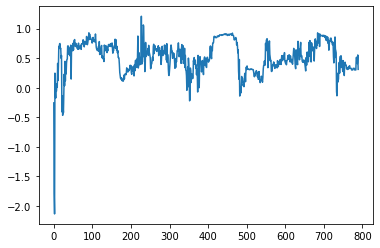

In [122]:
mx = nn[:,3,0]
mn = nn[:,3,1]
plt.plot((X[:,3,0]-mn)/(mx-mn))

In [110]:
df["nn_max"] = nn[:,0,:]
df["nn_min"] = nn[:,1,:]
plt.figure(figsize=(15,12));
N = 2
ax=plt.subplot(N,1,1);
df[["nn_max","nn_min",'close']].tail(300).plot(ax=ax);
ax=plt.subplot(N,1,2);
df[strats+["target_max","target_min"]].tail(300).plot(ax=ax);

NameError: name 'df' is not defined

In [28]:
x

NameError: name 'x' is not defined

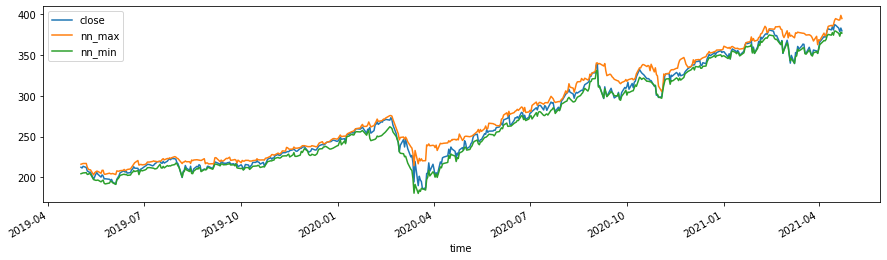

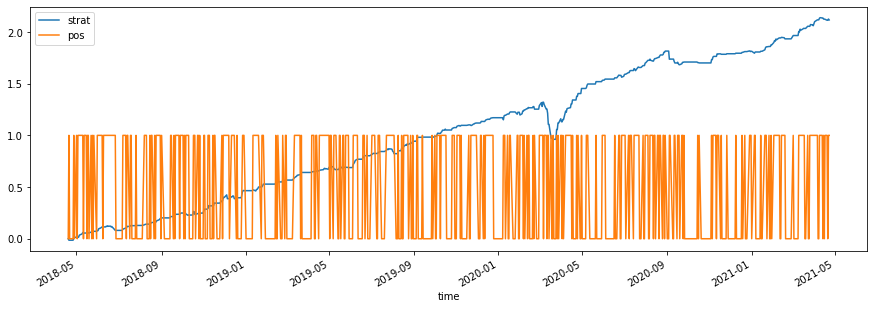

In [385]:
alpha = 4
beta = 0.1
nn_ = df['nn'].ewm(com=alpha)
buy_signal = 1.0*(df['nn'] > nn_.mean() - beta*nn_.std())
sell_signal = 1.0*(df['nn'] < nn_.mean() + beta*nn_.std())

pos = []
p = 0
for t in range(len(df["close"])):
    if p==0 and buy_signal[t]:
        p = 1
    elif p==1 and sell_signal[t]:
        p = 0
    pos.append(p)
df["pos"] = pos

df["r"] = df['close'].pct_change().fillna(0)
df["strat"] = (df["r"]*df["pos"]).cumsum()
df[['close',"nn_max","nn_min"]].tail(tail).plot(figsize=(15,4))
df[["strat","pos"]].plot(figsize=(15,5))